In [1]:
import sys

# Para podermos importar o utils
sys.path.append("../")

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf, acf
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from utils import wrangle_data
from collections import deque
from random import choice

In [3]:
# importando dados já limpos (sem duplicatas e com deltas)
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.tail()

,Data,Vacinados,Delta
2105,2021-02-20 13:35:00,1985642,624.0
2106,2021-02-20 14:10:00,1986750,1108.0
2107,2021-02-20 14:40:00,1987673,923.0
2108,2021-02-20 15:10:00,1988723,1050.0
2109,2021-02-20 15:40:00,1989589,866.0


In [4]:
"""
Separamos treino e teste antes de fazer o tratamento para que calculos como média e desvio padrão
não vazem informações de um conjunto para outro

TODO: esse split não considera a mudança no perio de pooling que foi feita no script
é preciso ajustar isso
"""
# 75/25
train_split = int(len(data) * .75)
train, test = data.iloc[:train_split], data.iloc[train_split:]

train = wrangle_data(train)
test = wrangle_data(test)

In [5]:
"""
A única coisa q pdoeria vazer de um ocnjunto para utro é o calculo de média e desvio padrão do
Lag-1 (Delta), como assumimos q é estacionário de variância fixa, isso n deve ser um problema
"""
clean_data = wrangle_data(data)
# 75/25
train_split = int(len(clean_data) * .75)
train, test = clean_data.iloc[:train_split], clean_data.iloc[train_split:]

# Modelo Sarima

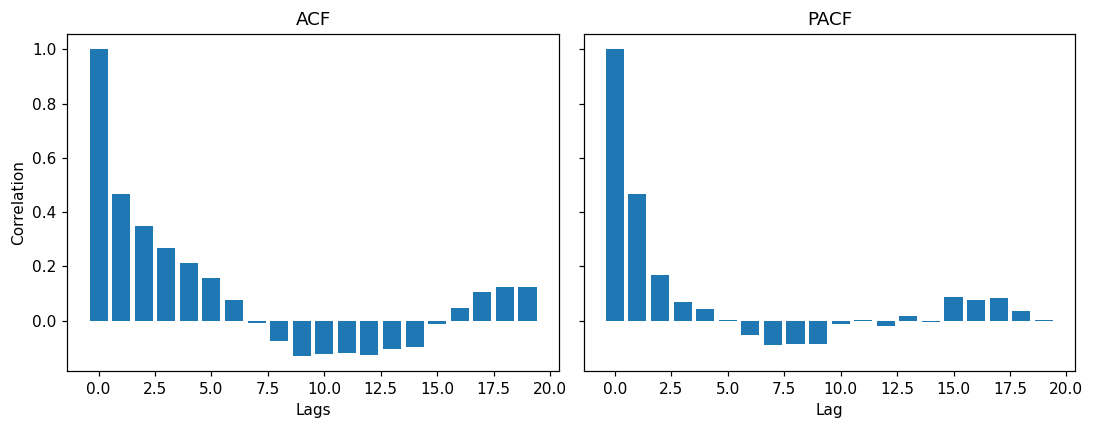

In [6]:
first_diff = train.diff()[1:]
num_lags = 20
acf_vals = acf(first_diff, nlags=num_lags, fft=False)
pacf_vals = pacf(first_diff, nlags=num_lags)

fig, ax = plt.subplots(ncols=2, figsize=(10,4), dpi=110, sharey=True)

ax[0].bar(range(num_lags), acf_vals[:num_lags])
ax[0].set(title="ACF",
         xlabel="Lags",
         ylabel="Correlation")

ax[1].bar(range(num_lags), pacf_vals[:num_lags])
ax[1].set(title="PACF",
         xlabel="Lag")
fig.tight_layout();

In [7]:
"""
Parametros q vamos utilizar em todos as otimizações feitas

method: método de otimização, escolhi um método derivative-free para evitar q regiões planas
ou com vários minimos impeçam o modelo de convergir

https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

maxiter: máximo de iterações antes de parar a otimização, 150 só pra garantir (padrão é 50)

disp: desliga o relatório da otimização
"""
opt_param = {'method': 'powell', 'maxiter':150, 'disp':0}

In [8]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

# Nossa grade de parametros para a busca
search_grid = {
    
    'order' : [
        (lag, 1, 1) for lag in range(6)
    ],
    
    'seasonal_order' : [
        (1, 1, 1, m) for m in range(16,32)
    ]
     
}
"""
Escolhe um conjunto de hiperparametros aleatórios
"""
def get_random_param_combination(grid):
    return {k: choice(values) for k,values in grid.items()}


"""
Dada uma grade de hiperparametros, testa diferentes combinações aleatórias
e retorna o conjunto com menor perda

train: conjunto de treino
test: conjunto de teste
grid: dicionário onde cada chave é um parametro e cada valor são listas de possíveis valores para esse parametro
iters: numero de combinações a testar (default 10)
loss: função de perda (default mean_absolute_error)
"""
def random_search_cv(train, test, grid, iters = 10, loss = mean_absolute_error):
    best_score = None
    best_params = None
    for i in range(iters):
        iter_scores = []
        parameters = get_random_param_combination(grid)
        model = SARIMAX(train, **parameters)
        fit = model.fit(**opt_param)
        predictions = fit.forecast(len(test))
        iter_score = loss(test, predictions)
        print(i, parameters, iter_score)
        if best_score is None or iter_score < best_score:
            best_score = iter_score
            best_params = parameters
    return best_params, best_score

In [9]:
best_params, score = random_search_cv(train, test, search_grid, iters=20)
#11/02/2021 -> (0,1,1), (1,1,1,23)

0 {'order': (4, 1, 1), 'seasonal_order': (1, 1, 1, 26)} 27266.604220444027
1 {'order': (4, 1, 1), 'seasonal_order': (1, 1, 1, 26)} 27266.604220444027
2 {'order': (4, 1, 1), 'seasonal_order': (1, 1, 1, 31)} 27856.267603261982
3 {'order': (5, 1, 1), 'seasonal_order': (1, 1, 1, 17)} 119605.03253857023
4 {'order': (5, 1, 1), 'seasonal_order': (1, 1, 1, 25)} 32559.06649191427
5 {'order': (3, 1, 1), 'seasonal_order': (1, 1, 1, 23)} 212784.51389710538
6 {'order': (4, 1, 1), 'seasonal_order': (1, 1, 1, 29)} 31215.758793445573
7 {'order': (3, 1, 1), 'seasonal_order': (1, 1, 1, 21)} 92698.13305577177
8 {'order': (5, 1, 1), 'seasonal_order': (1, 1, 1, 22)} 204034.5597639458
9 {'order': (4, 1, 1), 'seasonal_order': (1, 1, 1, 21)} 101574.70649703984
10 {'order': (3, 1, 1), 'seasonal_order': (1, 1, 1, 29)} 27008.484323846165
11 {'order': (0, 1, 1), 'seasonal_order': (1, 1, 1, 25)} 40336.76933820983
12 {'order': (2, 1, 1), 'seasonal_order': (1, 1, 1, 25)} 25648.78249666563
13 {'order': (5, 1, 1), 'se

In [10]:
best_params, score

({'order': (2, 1, 1), 'seasonal_order': (1, 1, 1, 25)}, 25648.78249666563)

In [ ]:
order= best_params['order']
season_order = best_params['seasonal_order']
"""
Faz o rolling forecast, prevendo sempre o próximo periodo e adicionando o
valor real ao próximo conjunto de treino dos dados
"""
def rolling_forecast(order, seasonal_order, train, test):
    forecasts = []
    
    initial = train.index.max()
    #Cópia local para não afetar objetos passados
    train_copy = list(train).copy()
    test_copy = list(test).copy()
    for obs in range(len(test_copy)):
        model = SARIMAX(train_copy, order=order, season_order=seasonal_order)
        fit = model.fit(**opt_param)
        prediction = fit.forecast(initial+obs)
        forecasts.append(prediction[0])
        # Adiciona o primeiro do conjunto de teste ao final do conjunto de treino
        train_copy.append(test_copy[0])
        test_copy = test_copy[1:]
    return forecasts

rolling = rolling_forecast(order, season_order, train, test)

In [ ]:
model = SARIMAX(list(train), order=order, seasonal_order=season_order)
model_fit = model.fit(**opt_param)

full_data = wrangle_data(data)

predictions = model_fit.forecast(len(test))
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(full_data.index, full_data, linestyle='--', alpha =0.7, label="Real")
ax.plot(test.index, predictions, label=f"SARIMA{order}{season_order}");
ax.plot(test.index, rolling, label=f"SARIMA{order}{season_order} Rolling Forecast")
ax.set(title=f"Comparação Real x Modelo",
       xlabel="Hora do Ano",
       ylabel="Número de Vacinados")
ax.grid()
ax.legend();

In [ ]:
# Computa os residuais
residuals = pd.Series(test - np.array(rolling))
# Gaussaibn Kernel Density Estimation para os nossos residuais
kde = gaussian_kde(residuals)

fig, ax = plt.subplots(ncols=2, figsize=(10,5), dpi=100)

fig.suptitle("Residuais (Rolling Forecast)")

ax[0].set(title="Residuais x Hora do Ano",
         xlabel="Hora do Ano",
         ylabel="Residuais")

ax[0].plot(residuals)

residuals.plot(kind='kde', ax=ax[1])

ax[1].set(title="Distribuição",
         xlabel="Residuais",
         ylabel="Prob.")
fig.tight_layout()


In [ ]:
residuals.describe()

In [ ]:
# Computa os residuais
residuals = pd.Series(test - np.array(predictions))
# Gaussaibn Kernel Density Estimation para os nossos residuais
kde = gaussian_kde(residuals)

fig, ax = plt.subplots(ncols=2, figsize=(10,5), dpi=100)

fig.suptitle("Residuais")

ax[0].set(title="Residuais x Hora do Ano",
         xlabel="Hora do Ano",
         ylabel="Residuais")

ax[0].plot(residuals)

residuals.plot(kind='kde', ax=ax[1])

ax[1].set(title="Distribuição",
         xlabel="Residuais",
         ylabel="Prob.")
fig.tight_layout()

In [ ]:
residuals.describe()

In [ ]:
errors = []

for i in range(1, len(test)-1):
    errors.append(mean_absolute_error(test[:i], predictions[:i]))

fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.set(title="Perfil de Erro do Forecast sem Rolamento",
         xlabel="Horas a Partir do Último dado real",
         ylabel="Erro Absoluto Médio")

ax.plot(errors)

fig.tight_layout()

In [ ]:
"""
Treinando um modelo com o melhor parametro de sazonalidade encontrado para tentar 
prever número de vacinados nas próximas horas
"""
model =SARIMAX(list(full_data), order=order, seasonal_order=season_order)
model_fit = model.fit(**opt_param)
hours_to_predict = 12
predictions = model_fit.forecast(hours_to_predict)
index = range(full_data.index.max()+1, full_data.index.max()+hours_to_predict+1)
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(full_data.index, full_data, label="Real")
ax.plot(index, predictions, label=f"SARIMA{order}{season_order}");
ax.set(title=f"Previsão das próximas {hours_to_predict} horas",
       xlabel="Hora do Ano",
       ylabel="Número de Vacinados")
ax.grid()
ax.legend();

In [ ]:
hora_zero = datetime(2021, 1, 1)
last_real_data = int(full_data.index.max())

print(f"Previsão de 12h a partir de {hora_zero + timedelta(hours=last_real_data)}")
for hora, vac in zip(index, predictions):
    data_vac = hora_zero + timedelta(hours=hora)
    print(f"{data_vac}: {vac:.0f}")